In [665]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from sklearn.model_selection import train_test_split

# Part I - Logistic Regression for Binary Classification

## Exercise 1 - Load the dataset

* Load the diabetes dataset (`diabetes.csv`)
* Make a 70/30% train test partition of the dataset

*Suggestion:* I suggest you load it with pandas, but make a scikit-learn style dataset ($X$, $y$ numpy arrays)

In [666]:
# your code goes here:
df_diabetes = pd.read_csv('diabetes.csv')

t = df_diabetes['Outcome'].to_numpy()
X = df_diabetes.drop('Outcome', axis=1).to_numpy()

# This time I'm using t for Target, so I don't confuse myself when look at the formulas
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.8, random_state=0)

t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

X_train = np.insert(X_train, 0, 1, axis=1)
X_train = (X_train -X_train.mean() ) / X_train.std()
X_test = np.insert(X_test, 0, 1, axis=1)
X_test = (X_test -X_test.mean() ) / X_test.std()

## Excercise 2 - Implementing Logistic Regression

* In this exercise you will implement the logistic regression algorithm to learn the vector of weights $\vec{w}$.
* You will then plot the ROC curve (using your implementation from the Tarefa), and calculate the AUROC (Area Under the ROC curve) using `sklearn.metrics.roc_auc_score()` for the testing set.

You can follow the structure for gradient descent as described in the previous labs and slides. Don't forget to write a function that calculates the sigmoid. You are not allowed in this exercise to use any existing functions.
* **Note that:** in the book and slides `y` is written as `t` and `y_hat` as `y`. 

Remember that $\nabla E(w) = \sum_{n=1}^N (y_n - t_n)\phi_n$ 

* _Tip:_ plot the loss during training to verify that everything is working properly.

In [667]:
def sigmoide(x):
    return 1 / (1 + math.e**(-x))

In [668]:
def cross_entropy_error_function(target: float, predicted: float) -> float:
    """Function that calculates the Cross Entropy error based on the values passed

    Args:
        target (float): Target value (0 or 1)
        predicted (float): Predicted value

    Returns:
        float: Error calculated
    """
    try:
        return -(target * math.log(predicted) + (1 - target)*math.log(1 - predicted))
    except ValueError:
        return math.inf  # This occures when target = 1 and predicted = 0 or vice-versa

In [669]:
def logistic_regression(X: np.ndarray, t: np.ndarray, eta: float | np.float64, epochs: int) -> np.ndarray:
    """This function makes a Logistic Regression using the Gradient Descent method

    Args:
        X (np.ndarray): Matrix with the features to use for prediction
        t (np.ndarray): The target array
        eta (np.ndarray): The coefficient that tells how much the gradient influences strengh on the decay
        epochs (int): How many times the algorithm will learn

    Returns:
        np.ndarray: weight vector
    """
    t = t.reshape(-1, 1)

    w = np.zeros(shape=(X.shape[1], 1))

    for _ in range(epochs):
        j = 0
        
        for point in X:
            point = point.reshape(-1, 1)

            y_pred = sigmoide((w.T @ point)[0,0])
            gradient = (y_pred - t[j, 0]) * point
            w -= eta * gradient

            j += 1

    return w

In [670]:
def get_fpr_tpr(predicted_values: np.ndarray, true_labels: np.ndarray, threshold: float):
    # If we are going to use only the second column, I'm going to get all the values of the second column
    
    data_dataframe = pd.DataFrame()  # Creating a dataframe to make easier calculations and operations

    # Creating the dataframe's columns
    data_dataframe['being_one_percentage'] = pd.Series(predicted_values.flatten())
    data_dataframe['true_labels'] = pd.Series(true_labels.flatten())

    # Calculating the results based on the threshold
    data_dataframe['result_by_threshold'] = data_dataframe['being_one_percentage'] >= threshold

    # Getting the informations to calculate TPR & FPR
    true_positives = len(data_dataframe[
        (data_dataframe['result_by_threshold'] == True) & (data_dataframe['true_labels'] == True)
    ])
    false_negatives = len(data_dataframe[
        (data_dataframe['result_by_threshold'] == False) & (data_dataframe['true_labels'] == True)
    ])
    true_negatives = len(data_dataframe[
        (data_dataframe['result_by_threshold'] == False) & (data_dataframe['true_labels'] == False)
    ])
    false_positives = len(data_dataframe[
        (data_dataframe['result_by_threshold'] == True) & (data_dataframe['true_labels'] == False)
    ])

    tpr = true_positives / (true_positives + false_negatives)
    fpr = false_positives / (false_positives + true_negatives)

    return fpr, tpr

Evaluate the performance of your model, plot the ROC curve and calculate the AUROC

In [671]:
from sklearn.metrics import roc_auc_score

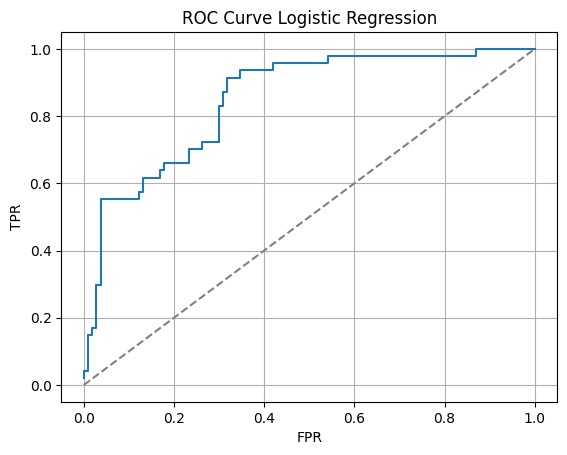

np.float64(0.8496719029628157)

In [672]:
# The threshold values are the values of the prediction!
w = logistic_regression(X_train, t_train, 0.01, 1000)
y_predicted = sigmoide(X_test @ w)


def generate_informations_for_model(y_model: np.ndarray, target: np.ndarray):
    """This functions is responsible for generate samples for the graphic plot in the ROC curve

    Args:
        y_model (np.ndarray): The array containing the output values generated by the model
        samples_number (int): The amount of samples it will return
    """

    # Creating the series we are going to return (Each line has a different threshold)
    false_positive_rates = []
    true_positive_rates = []

    # Getting the informations
    for threshold in np.unique(y_model):
        fpr, tpr = get_fpr_tpr(y_model, target, threshold)  # Obtaining the rates

        # Applying the rates on each series
        false_positive_rates.append(fpr)
        true_positive_rates.append(tpr)
    
    # Returning my results
    return false_positive_rates, true_positive_rates


false_positive_rates, true_positive_rates = generate_informations_for_model(y_predicted, t_test)

plt.title("ROC Curve Logistic Regression")

plt.plot(false_positive_rates, true_positive_rates)
plt.xlabel("FPR")
plt.ylabel("TPR")

x = y = np.linspace(0, 1, 2)
plt.plot(x, y, '--', color='gray')

plt.grid()

plt.show()

roc_auc_score(t_test, y_predicted)

# Part IV - Logistic Regression for multi-class classification

## Exercise 1 - Load the dataset
* Load the famous Iris dataset (using sklearn as shown below)
* Load the data in a matrix $X$ and the target in a vector $y$.
* Make a 70/30% train test partition of the dataset

In [673]:
from sklearn.datasets import load_iris

In [674]:
iris = load_iris()

Prepare $X$ and $y$

In [675]:
X = iris.data
t = iris.target

Split the data

In [676]:
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=.7, random_state=0)

## Exercise 2 - Train the Logistic Regression model
Train your LogisticRegression multi-class classifier using the sklearn implementation. 
* To use the cross entropy loss function and softmax activation function, the `multi_class` parameter needs to be set to "multinomial"

In [677]:
from sklearn.linear_model import LogisticRegression

In [678]:
# Let's create an instance of the LogisticRegression classifier for multiclass classification
lr_iris = LogisticRegression(solver='newton-cg')
# I removed the multi_class parameter just to remove the warning given in the next code block

Fit the data

In [679]:
lr_iris.fit(X_train, t_train)

LogisticRegression(solver='newton-cg')

## Exercise 3 - Make predictions and evaluate the model
Use the `predict_proba()` method to obtain the output of the predictions for the testing set. The values are the output of the softmax activation function. 
* Remember that the highest value of each prediction corresponds to the actual predicted class.
* Write a function `get_predicted_class()` that transforms the vector of softmax outputs (obtained from `predict_proba()`) to a vector that just contains the predicted class. 
    - This function takes as input a matrix $\hat{Y}_{proba} \in \mathbb{R}^{m\times k}$ where $m$ is the number of samples in the testing set and $k$ is the number of classes.

As an example: if the softmax output is as follows: `Y_pred_sm = [[0.1,0.2,0.7], [0.4,0.3,0.3]]`, then `get_predicted_class(Y_pred_sm)` should return: `[2,0]` as the highest value for the 1st prediction is class 2 and for the 2nd prediction is class 0.

In [680]:
def get_predicted_class(Y_proba):
    """This functions get a matrix containing the probabilities for each datapoint being of class Ci
    and returns a vector where wich j-th entry represents the class that the j-th datapoint is most
    probably asigned

    Args:
        predicted_classes (np.ndarray): Matrix with m lines and k columns, where m is the number of datapoints
        and k is the number of classes

    Returns:
        np.ndarray: Array where the j-th column is the class wich the j-th datapoint is most probable
    """
    y_pred = np.zeros(shape=(Y_proba.shape[0], 1))
    
    for j, datapoint in enumerate(Y_proba):
        for k, ck in enumerate(datapoint):  # Ck stands for Class k
            if ck == max(datapoint):
                y_pred[j] = k
    
    return y_pred

In [681]:
# complete the input argument for t1he function to obtain the predictions for the testing set.
y_pred_sm = lr_iris.predict_proba(X_test)
y_pred = get_predicted_class(y_pred_sm)

Now calculate the accuracy in the testing set using `y_pred`
- Try calculating the accuracy without using the sklearn function :)

In [682]:
def get_measures(predicted_values: np.ndarray, true_labels: np.ndarray):
    # If we are going to use only the second column, I'm going to get all the values of the second column
    predicted_values = predicted_values.reshape(-1, 1)
    true_labels = true_labels.reshape(-1, 1)

    TP = np.ones(shape=(predicted_values.shape))[predicted_values == true_labels].sum()
    FP = np.ones(shape=(predicted_values.shape))[predicted_values != true_labels].sum()

    return TP, FP

In [683]:
TP, FP = get_measures(y_pred, t_test)

accuracy = TP / (TP + FP)

print(f"The test accuracy is {accuracy}")

The test accuracy is 0.9777777777777777
